# EDA

In [ ]:
!unzip drive/MyDrive/integrant.zip

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from pathlib import Path
import random
random.seed(0)
path = Path('/content/semantic_segm_data/train')
fnames = list(path.glob('*.jpg'))

Возьмём случайные 10 фотографий и посмотрим на них

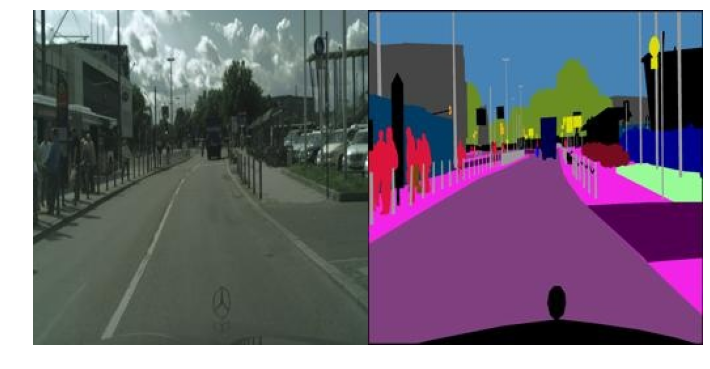

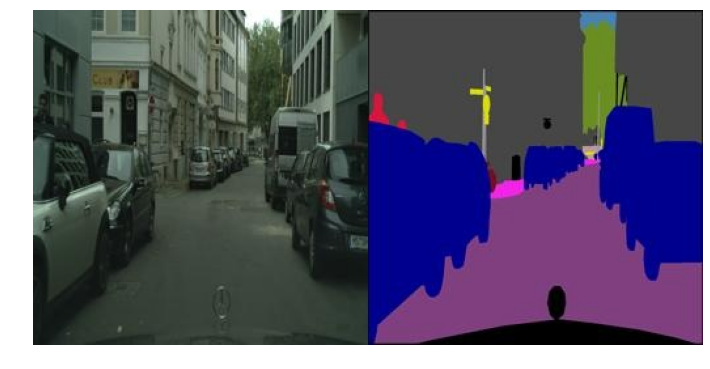

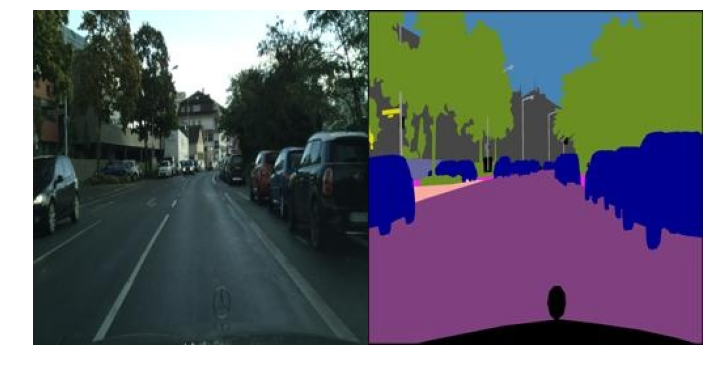

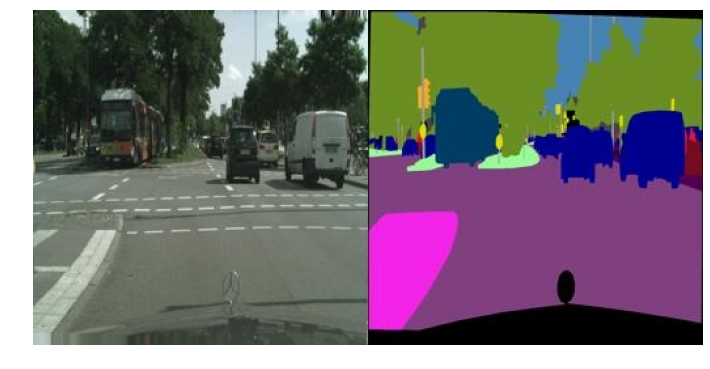

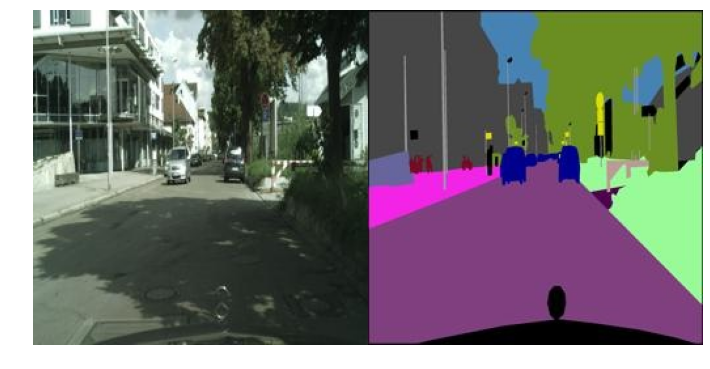

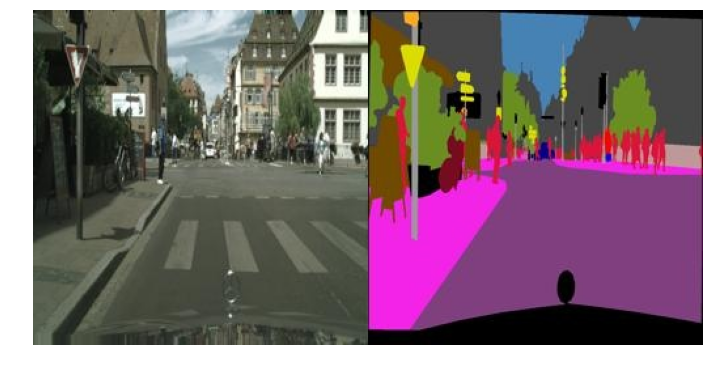

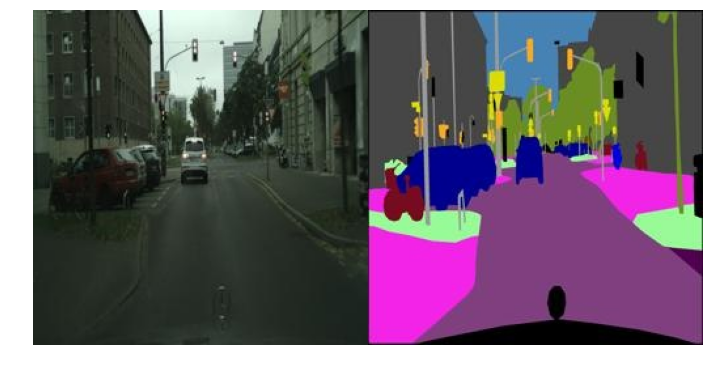

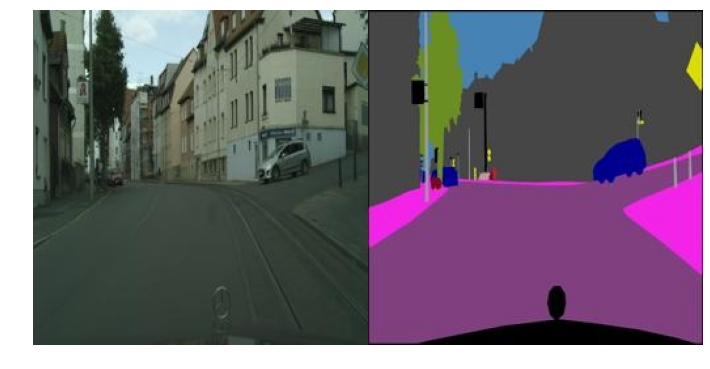

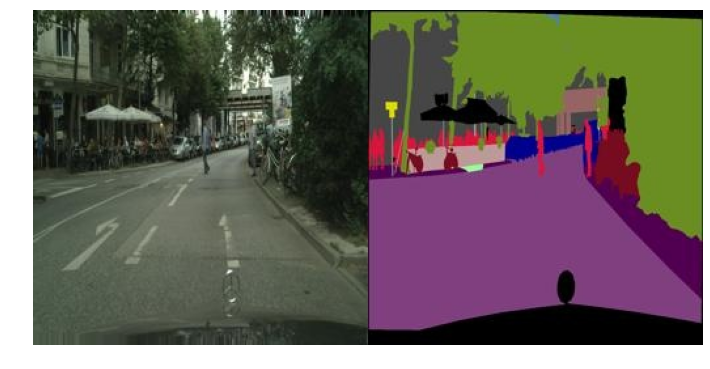

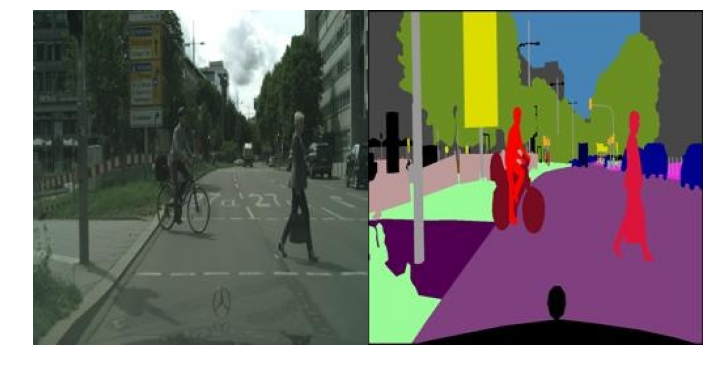

In [ ]:
imgs, masks = [], []
for img_file in random.choices(fnames, k=10):
    plt.figure(figsize=(12,8))
    img_mask = cv.imread(str(img_file))[..., ::-1]
    imgs.append(img_mask[:, :256, :])
    masks.append(img_mask[:, 256:, :])

    plt.imshow(img_mask)
    plt.show()

In [ ]:
print(f'Размер фотографии: {img_mask.shape[1]}x{img_mask.shape[0]}')

Размер фотографии: 512x256


Видим, что фотографии содержат одновременно снимок и его маску. Таким образом, мы будем сплитить каждую фотографию на X и y. Мы будем предсказывать области, содержащие человека (красные сегменты) или машину (синие сегменты). Если приглядеться, то можно заметить, что цвета не всегда чёткие, то есть варьируются в каком-то диапазоне. Это связано с потерей качества при сжатии фотографии. Попробуем подобрать нужные диапазоны.

![hue bar](https://i.stack.imgur.com/YOBFy.png)

Выше приведена шкала оттенков (hue) в цветовой модели HSV. Получить нужный цвет из такой модели намного проще, чем из RGB. Подберём нужные интервалы

In [ ]:
def red_mask(img_rgb):
    img_hsv=cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)

    lower_red = np.array([0,100,130])
    upper_red = np.array([10,255,255])

    mask0 = cv.inRange(img_hsv, lower_red, upper_red)

    lower_red = np.array([170,100,130])
    upper_red = np.array([180,255,255])
    mask1 = cv.inRange(img_hsv, lower_red, upper_red)

    mask = cv.bitwise_or(mask0, mask1)
    return mask

In [ ]:
def blue_mask(img_rgb):
    img_hsv=cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)

    lower_blue = np.array([110,100,50])
    upper_blue = np.array([130,255,255])
    mask = cv.inRange(img_hsv, lower_blue, upper_blue)

    return mask

На получившихся масках был лишний шум. Для его избавления применим морфологические трансформации с подобранным окном kernel

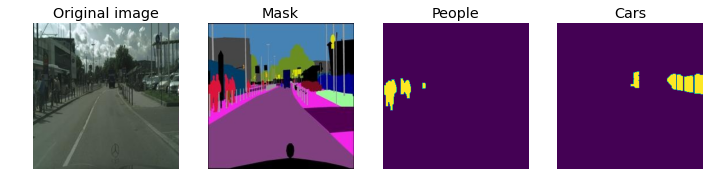

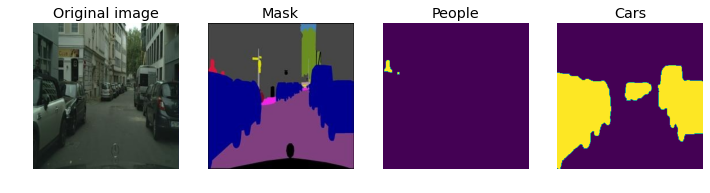

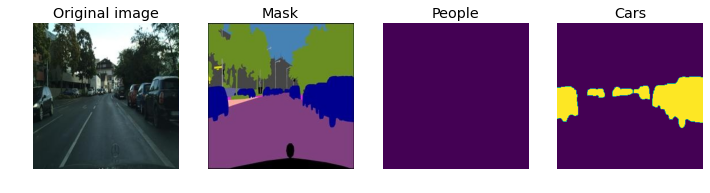

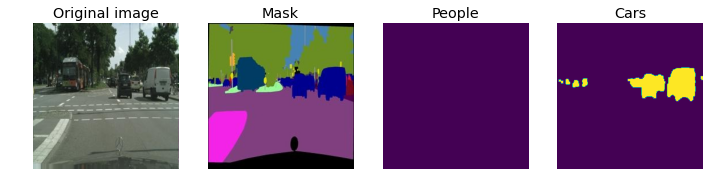

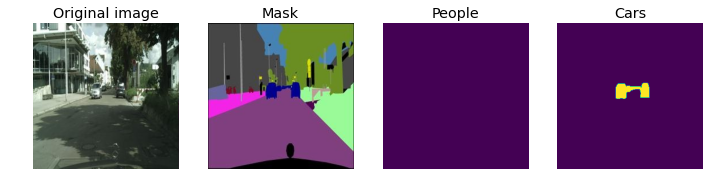

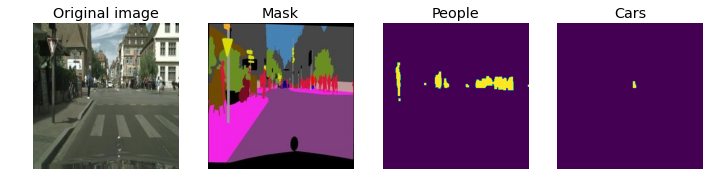

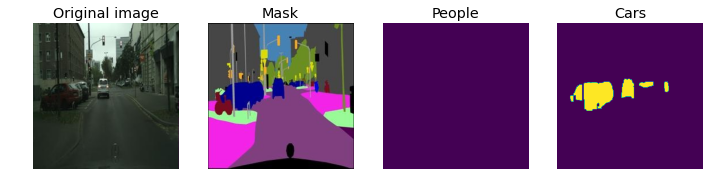

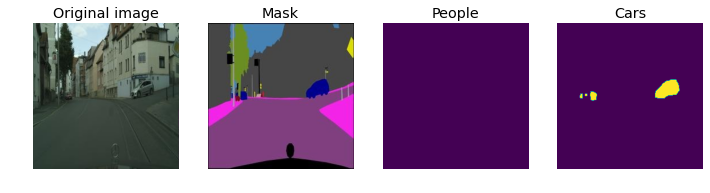

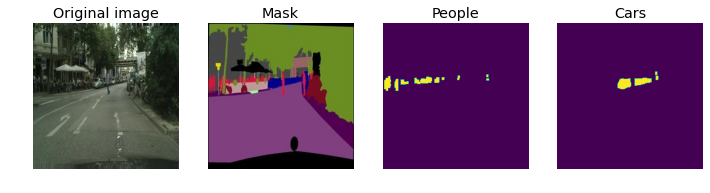

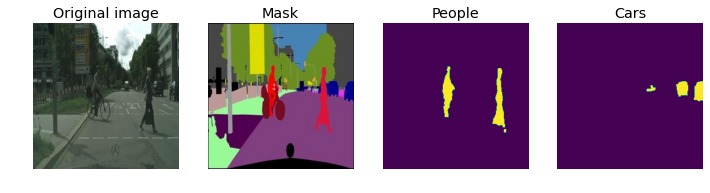

In [ ]:
import numpy as np
kernel = np.ones((4,4),np.uint8)

for img, mask in zip(imgs, masks):
    plt.figure(figsize=(12,8))
    plt.subplot(141)
    plt.title('Original image')
    plt.imshow(img)

    plt.subplot(142)
    plt.title('Mask')
    plt.imshow(mask)

    plt.subplot(143)
    plt.title('People')
    people = red_mask(mask)
    people = cv.morphologyEx(people, cv.MORPH_OPEN, kernel)
    plt.imshow(people)

    plt.subplot(144)
    plt.title('Cars')
    cars = blue_mask(mask)
    cars = cv.morphologyEx(cars, cv.MORPH_OPEN, kernel)
    plt.imshow(cars)

    plt.show()

Видим, что всё очень хорошо сегментируется

# Объявление класса датасета

Для получения очередной пары (X, y) мы применим вышесказанную предобработку: разрезание фотографии, обнаружение масок людей и машин, после чего получим результатирующую маску, содержащую следующие значения: 0 - задний фон, 1 - человек, 2 - машина

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F

class CarDataset(Dataset):
    def __init__(self, path, phase='train'):
        path = Path(path)
        self.filenames = list(path.glob('*.jpg'))

        
    def __getitem__(self, idx):
        filename = str(self.filenames[idx])
        img_mask = cv.imread(filename)[..., ::-1]
        img = img_mask[:, :256, :].copy()
        mask = img_mask[:, 256:, :].copy()

        red_mask = self.red_mask(mask) // 255
        red_mask = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel)

        blue_mask = self.blue_mask(mask) // 255
        blue_mask = cv.morphologyEx(blue_mask, cv.MORPH_OPEN, kernel)

        mask = red_mask + 2 * (blue_mask)

        return F.to_tensor(img), torch.LongTensor(mask)
    
    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def red_mask(img_rgb):
        img_hsv=cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)

        lower_red = np.array([0,100,130])
        upper_red = np.array([10,255,255])

        mask0 = cv.inRange(img_hsv, lower_red, upper_red)

        lower_red = np.array([170,100,130])
        upper_red = np.array([180,255,255])
        mask1 = cv.inRange(img_hsv, lower_red, upper_red)

        mask = cv.bitwise_or(mask0, mask1)
        return mask

    @staticmethod
    def blue_mask(img_rgb):
        img_hsv=cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)

        lower_blue = np.array([110,100,50])
        upper_blue = np.array([130,255,255])
        mask = cv.inRange(img_hsv, lower_blue, upper_blue)

        return mask

In [ ]:
CLASSES = ['background', 'people', 'cars']

train_ds = CarDataset('/content/semantic_segm_data/train')
val_ds = CarDataset('/content/semantic_segm_data/val')

train_dl =  DataLoader(train_ds, batch_size=24, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=24, shuffle=False)

# X, y = next(iter(train_dl))

Посмотрим на распределение классов

In [ ]:
freqs = np.array([0]*3)
for _, y in train_dl:
    freqs += np.bincount(y.numpy().ravel())

class_distr = freqs / freqs.sum()

for i in range(3):
    print(f'{CLASSES[i]}: {class_distr[i]:.2f}')

background: 0.92
people: 0.01
cars: 0.07


Видим, что машины занимают в 7 раз больше области, чем люди. Это стоит иметь ввиду при оценке качества моделей

# Объявление модели

Объявим первоначальную модель UNet

In [ ]:
import torch
from torch import nn

def down_conv(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )
    
def up_conv(in_channels, hidden_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),

            nn.Conv2d(hidden_channels, out_channels, 3, padding=1),
            nn.ReLU(),
        )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = down_conv(3, 64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128

        self.enc_conv1 = down_conv(64, 128)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64

        self.enc_conv2 = down_conv(128, 256)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32

        self.enc_conv3 = down_conv(256, 512)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 1),
            nn.ReLU(),

            nn.Conv2d(1024, 512, 1),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)# 16 -> 32
        self.dec_conv0 = up_conv(512+512, 256, 256)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) # 32 -> 64
        self.dec_conv1 = up_conv(256+256, 256, 128)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)   # 64 -> 128
        self.dec_conv2 = up_conv(128+128, 128, 64)
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 128 -> 256
        self.dec_conv3 = up_conv(64+64, 64, 64)

        self.out_conv = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 64x256x256
        e1 = self.enc_conv1(self.pool0(e0)) # 128x128x128
        e2 = self.enc_conv2(self.pool1(e1)) # 256x64x64
        e3 = self.enc_conv3(self.pool2(e2)) # 512x32x32

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) # 512x16x16

        # decoder
        x = self.dec_conv0( torch.cat((e3, self.upsample0(b)), dim=1) ) # (512+512)x32x32
        x = self.dec_conv1( torch.cat((e2, self.upsample1(x)), dim=1) ) # (256+256)x64x64
        x = self.dec_conv2( torch.cat((e1, self.upsample2(x)), dim=1) ) # (128+128)x128x128
        x = self.dec_conv3( torch.cat((e0, self.upsample3(x)), dim=1) ) # (64+64)x256x256
        x = self.out_conv(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3).to(device)

In [ ]:
model

UNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Видим, что для пропуска фотографии и градиентов необходимо ~600 МБ. Следовательно, чтобы батч фотографий вместился на видеокарту с памятью 16GB, размер батча должен быть (16*1024/600) % 8 = 24

# Объявление вспомогательных функций обучения

In [ ]:
# plot learning curves
def plot_lc(tr_loss, val_loss):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(tr_loss, label='Train loss')
    ax.plot(val_loss, label='Val loss')
    ax.set_xlabel('Num epoch')
    ax.set_ylabel('Loss')
    plt.axis('on')
    ax.legend()
    plt.show()

In [ ]:
# returns original mask and predicted mask
def inference_batch(model, dataloader):
    model.eval()
    X, y = next(iter(dataloader))
    with torch.no_grad():
        y_pred = model(X.cuda()).argmax(1).cpu()
    return y, y_pred

In [ ]:
def show_masks(y, y_pred):
    fig, axes = plt.subplots(3, 5, figsize=(25,8));
    for i, ax in enumerate(axes.transpose()):
        ax[0].set_title('original mask')
        ax[0].imshow(y[i])
        ax[0].axis('off')

        ax[1].set_title('predicted people mask')
        ax[1].imshow(y_pred[i].numpy() == 1)
        ax[1].axis('off')

        ax[2].set_title('predicted car mask')
        ax[2].imshow(y_pred[i].numpy() == 2)
        ax[2].axis('off')

    fig.suptitle(f'Epoch: {len(tr_loss)} Train loss: {tr_loss[-1]:.3f}/ Val loss: {val_loss[-1]:.3f}')
    plt.grid()
    plt.show()

In [ ]:
# fitting epoch/evalute
def forward_epoch(model, loss_fn, opt, dataloader, steps, losses, phase):
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0.
    for step, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        opt.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            if phase == 'train':
                loss.backward()
                opt.step()
            
            epoch_loss += loss.item()
        if step + 1 == steps: 
            break
    losses.append(epoch_loss / len(dataloader))

In [ ]:
from tqdm.notebook import trange
from IPython.display import clear_output

def train(model, loss_fn, opt, scheduler, num_epoch, train_dl, val_dl, train_steps=None, val_steps=None):
    # t = trange(num_epoch, unit='epoch')
    for epoch in range(num_epoch):
        forward_epoch(model, loss_fn, opt, train_dl, train_steps, tr_loss, phase='train')
        forward_epoch(model, loss_fn, opt, val_dl, val_steps, val_loss, phase='val')
        scheduler.step(val_loss[-1])
        y, y_pred = inference_batch(model, val_dl)

        clear_output()
        show_masks(y, y_pred)
        plot_lc(tr_loss, val_loss)

        if val_loss[-1] < min(val_loss[:-1]):
            torch.save(model, save_path)
            print('Model saved')
        # t.set_description(f'{tr_loss[-1]:.3f}/{val_loss[-1]:.3f}')
        # t.update(1)

# Обучение нейросети

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=7)
save_path = 'drive/MyDrive/itegrant/model_simple_unet.pth'

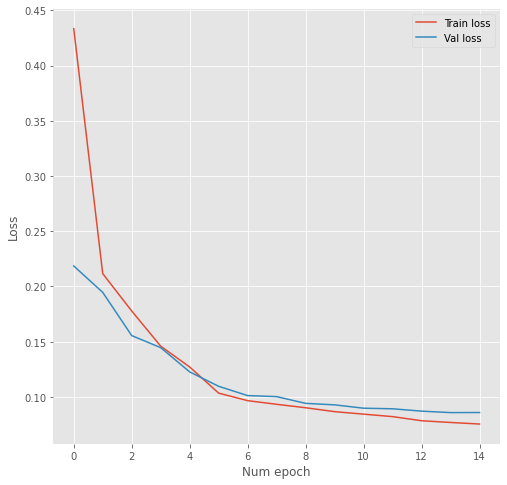

In [ ]:
if False:
    tr_loss, val_loss = [], []

train(model, loss_fn, opt, scheduler, 15, train_dl, val_dl)

Посмотрим на получившиеся сегментации

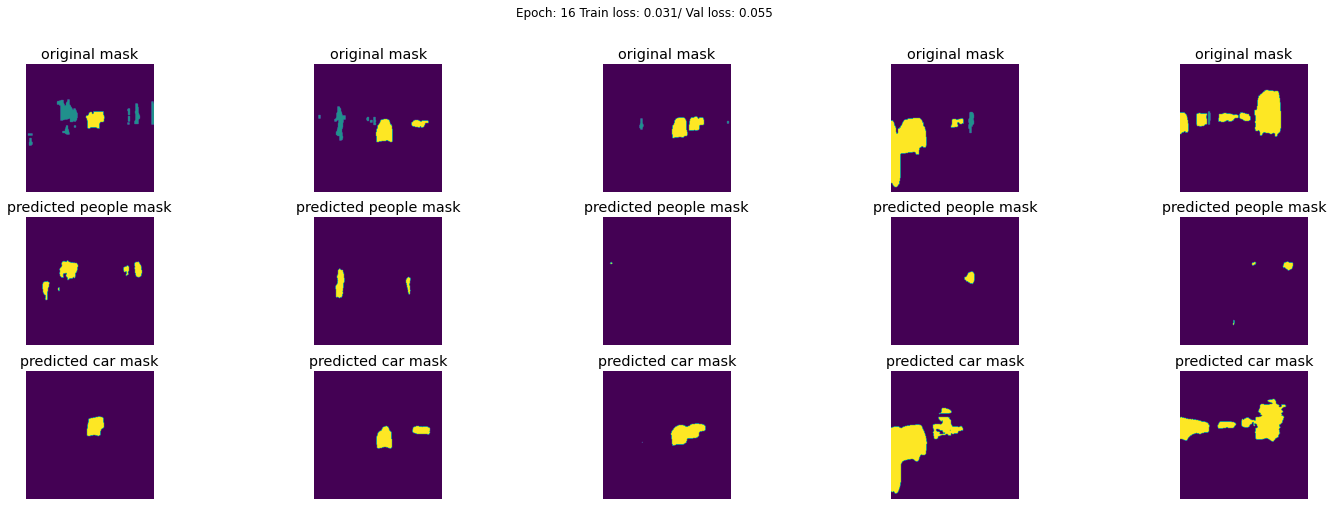

In [ ]:
y, y_pred = inference_batch(model, val_dl)
show_masks(y, y_pred)

# Оценка качества нейросети

In [ ]:
def iou(y_true: torch.Tensor, y_pred: torch.Tensor, n_class):
    y_true = y_true == n_class
    y_pred = y_pred == n_class
    
    inter = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()

    return inter / (union + 1e-8)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = np.array([0., 0.])
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device)).argmax(1)
            scores[0] += metric(Y_label.to(device), Y_pred, 1).item()
            scores[1] += metric(Y_label.to(device), Y_pred, 2).item()

    return scores / len(data)

In [ ]:
people_iou, car_iou = score_model(model, iou, val_dl)
print('People IoU:', round(people_iou, 2))
print('Car IoU:', round(car_iou, 2))

People IoU: 0.21
Car IoU: 0.7


Получили хорошее значение IoU для класса машины, а вот с определением человека не всё так хорошо. Попробуем построить другую модель

# Другая модель

Архитектура данной модель будет иметь в качестве энкодера предобученный ResNet, а также будут добавлены BatchNorm слои для ускоренной сходимости

In [ ]:
import torch
from torch import nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)        
        
        return out

In [ ]:
model = ResNetUNet(3).to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]           9,408
            Conv2d-8         [-1, 64, 128, 128]           9,408
       BatchNorm2d-9         [-1, 64, 128, 128]             128
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
             ReLU-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

Для пропуска фотографии через новую модель уже потребуется ~800 МБ. Следовательно, придётся понизить размер батча до 16.

In [ ]:
train_dl =  DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=7)
save_path = 'drive/MyDrive/itegrant/unet_resnet.pth'

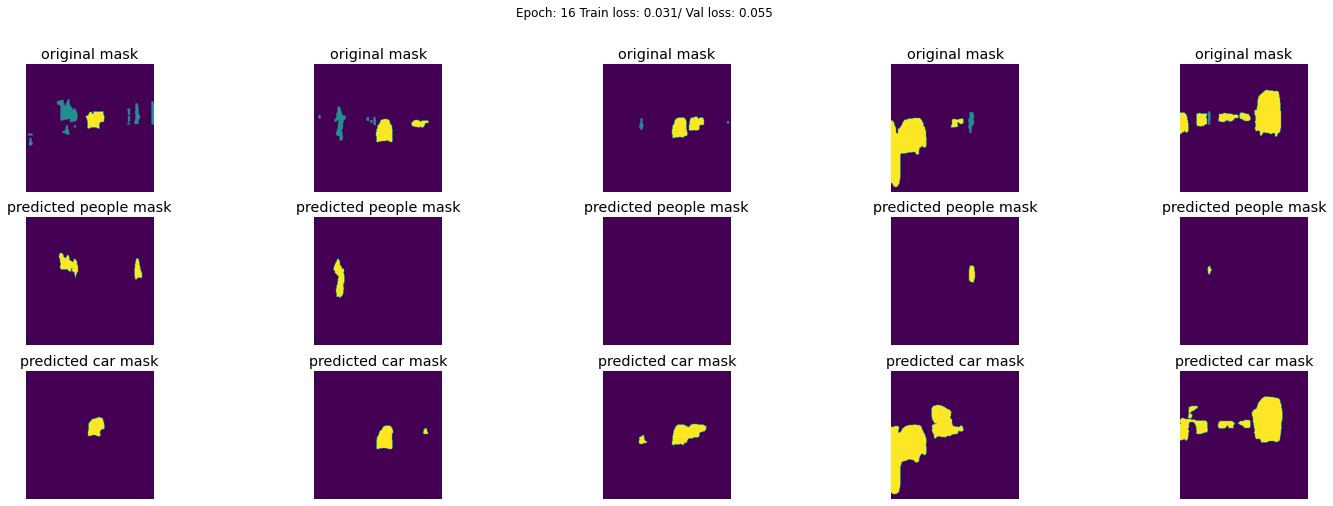

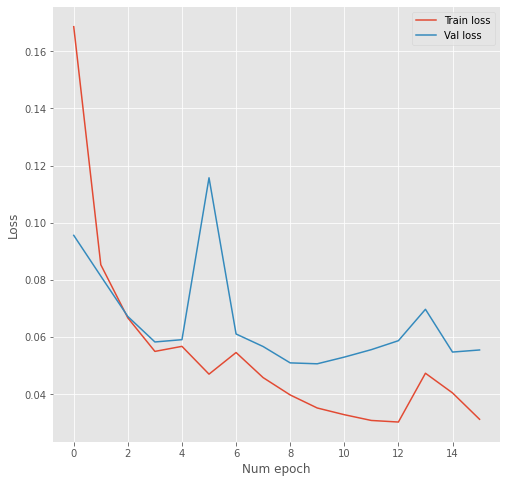

In [ ]:
if False:
    tr_loss, val_loss = [], []

train(model, loss_fn, opt, scheduler, 16, train_dl, val_dl)

Видим, что модель быстрее сошлась за счёт предобученности. Посмотрим метрики

In [ ]:
people_iou, car_iou = score_model(model, iou, val_dl)
print('People IoU:', round(people_iou, 2))
print('Car IoU:', round(car_iou, 2))

People IoU: 0.47
Car IoU: 0.83


Видим, что IoU подрос как для сегментации людей, так и для машин. Тем не менее, IoU для человека не даёт уверенности, особенно, когда речь идёт о беспилотных автомобилях. Помним, что у нас наблюдается дизбаланс классов, поэтому посмотрим на другие метрики (Precision, Recall, F1)

In [ ]:
def tp_cnt(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (y_true & y_pred).sum()

def fp_cnt(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (~y_true & y_pred).sum()

def fn_cnt(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (y_true & ~y_pred).sum()

def get_tp_fp_fn(model, data, n_class):
    model.eval()
    tp = np.array([0]*n_class)
    fp = np.array([0]*n_class)
    fn = np.array([0]*n_class)
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device)).argmax(1)

            for i in range(n_class):
                tp[i] += tp_cnt(Y_label.to(device)==i, Y_pred==i).item()
                fp[i] += fp_cnt(Y_label.to(device)==i, Y_pred==i).item()
                fn[i] += fn_cnt(Y_label.to(device)==i, Y_pred==i).item()

    return tp, fp, fn

In [ ]:
def precision_score(tp, fp):
    return tp / (tp + fp)

def recall_score(tp, fn):
    return tp / (tp + fn)

def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

def print_metrics(tp, fp, fn):
    precision = precision_score(tp, fp)
    recall = recall_score(tp, fn)
    f1 = f1_score(precision, recall)
    df = pd.DataFrame([precision.round(2), recall.round(2), f1.round(2)], 
                      index=['precision', 'recall', 'f1'], 
                      columns=CLASSES).T
    print(df)

In [ ]:
tp, fp, fn = get_tp_fp_fn(model, val_dl, 3)
print_metrics(tp, fp, fn)

            precision  recall    f1
background       0.99    0.99  0.99
people           0.72    0.61  0.66
cars             0.90    0.91  0.91


Здесь уже можем видеть хорошие значения F1 для целевых классов. В то же время, значение recall у человека меньше, чем precision. Довольно рискованно оставлять эти две метрики в таком соотношении. Здесь лучше было бы допустить ошибку первого рода - FP (когда модель ошибочно считает, что пиксель принадлежит классу человек), понизив порог вероятности определения человека при написании алгоритма

# Заключение

Таким образом, был построен пайплайн обучения для решения задачи сегментаци, обучены две модели и проведена оценка качества по различным метрикам. Задание заключалось в исследовании данных, а также построении и оценке различных нейросетевых архитектур. Чего ещё можно было добавить - это более длительное обучение моделей, так как видно, что значение лосс функции не выходило на плато; различные аугментации: горизонтальное отражение, изменение яркости, случайная обрезка